In [1]:
!pip install nltk

In [2]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
import matplotlib                  # 2D Plotting Library
import geopandas as gpd            # Python Geospatial Data Library
plt.style.use('fivethirtyeight')
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#preprocessing
from nltk.corpus import stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

stop_words=set(nltk.corpus.stopwords.words('english'))

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/labeledTrainData.tsv', delimiter='\t', quoting=3)

In [5]:
df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
index = df.index
number_of_rows = len(index)
print(number_of_rows)

25000


In [7]:
new1 = df[['review']].copy()

In [8]:
print (new1)

                                                  review
0      "With all this stuff going down at the moment ...
1      "\"The Classic War of the Worlds\" by Timothy ...
2      "The film starts with a manager (Nicholas Bell...
3      "It must be assumed that those who praised thi...
4      "Superbly trashy and wondrously unpretentious ...
...                                                  ...
24995  "It seems like more consideration has gone int...
24996  "I don't believe they made this film. Complete...
24997  "Guy is a loser. Can't get girls, needs to bui...
24998  "This 30 minute documentary Buñuel made in the...
24999  "I saw this movie as a child and it broke my h...

[25000 rows x 1 columns]


### DATA CLEANING & PRE-PROCESSING
Here I have done the data pre-processing. We can use any among the lemmatization and the stemming but i prefer to use lemmatiation. Also the stop words have been removed.

In [9]:
# def clean_text(review):
#     le=WordNetLemmatizer()
#     word_tokens=word_tokenize(review)
#     tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
#     cleaned_text=" ".join(tokens)
#     return cleaned_text

In [10]:
!pip show BeautifulSoup4

Name: beautifulsoup4
Version: 4.12.3
Summary: Screen-scraping library
Home-page: 
Author: 
Author-email: Leonard Richardson <leonardr@segfault.org>
License: MIT License
Location: /usr/local/lib/python3.10/dist-packages
Requires: soupsieve
Required-by: gdown, google, nbconvert, yfinance


In [11]:
from bs4 import BeautifulSoup
# 정규표현식을 사용해서 특수문자를 제거
import re

In [12]:
stemmer = SnowballStemmer('english')

In [13]:
def clean_text(raw_review):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [14]:
#it takes time
new1['cleaned_text']=new1['review'].apply(clean_text)

<ipython-input-13-f8b70ae067ee>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [15]:
new1.head()

,review,cleaned_text
0,"""With all this stuff going down at the moment ...",stuff go moment mj start listen music watch od...
1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war world timothi hine entertain film ...
2,"""The film starts with a manager (Nicholas Bell...",film start manag nichola bell give welcom inve...
3,"""It must be assumed that those who praised thi...",must assum prais film greatest film opera ever...
4,"""Superbly trashy and wondrously unpretentious ...",superbl trashi wondrous unpretenti exploit hoo...


You can clearly see the difference after removal of stopwords and some shorter words.

> Now drop the unpre-processed column.

In [16]:
new1.drop(['review'],axis=1,inplace=True)

### EXTRACTING THE FEATURES AND CREATING THE DOCUMENT-TERM-MATRIX ( DTM )
A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

Some important points:-

1) LSA is generally implemented with Tfidf values everywhere and not with the Count Vectorizer.

2) max_features depends on your computing power and also on eval. metric (coherence score is a metric for topic model). Try the value that gives best eval. metric and doesn't limits processing power.

3) Default values for min_df & max_df worked well.

4) Can try different values for ngram_range.

In [17]:
# vect =TfidfVectorizer(stop_words=stop_words,max_features=1000)
# vect =TfidfVectorizer(stop_words=None,max_features=1000)
vect =TfidfVectorizer(stop_words=None,min_df = 2,max_features=20000)

In [18]:
vect_text=vect.fit_transform(new1['cleaned_text'])

In [19]:
print(vect.get_feature_names_out())

['aa' 'aaa' 'aag' ... 'zulu' 'zuniga' 'zwick']


We can now see the most frequent and rare words in the cleaned_text column based on idf score. The lesser the value; more common is the word in the column.

In [20]:
print(vect_text.shape)
type(vect_text)

(25000, 20000)


scipy.sparse._csr.csr_matrix

In [21]:
idf=vect.idf_

In [22]:
dd=dict(zip(vect.get_feature_names_out(), idf))
l=sorted(dd, key=(dd).get)
print(l)
print(l[0],l[-1])
print(dd['like'])
print(dd['success'])

['movi', 'film', 'one', 'like', 'time', 'good', 'make', 'see', 'watch', 'get', 'even', 'charact', 'would', 'stori', 'realli', 'well', 'much', 'look', 'act', 'end', 'go', 'scene', 'way', 'first', 'great', 'also', 'think', 'made', 'peopl', 'bad', 'thing', 'could', 'love', 'play', 'know', 'say', 'show', 'seem', 'seen', 'come', 'plot', 'work', 'actor', 'take', 'want', 'year', 'mani', 'never', 'two', 'best', 'tri', 'littl', 'ever', 'give', 'better', 'life', 'still', 'find', 'someth', 'part', 'back', 'perform', 'man', 'feel', 'interest', 'actual', 'director', 'use', 'lot', 'cast', 'real', 'anoth', 'though', 'enjoy', 'old', 'noth', 'live', 'set', 'start', 'point', 'direct', 'star', 'everi', 'believ', 'turn', 'new', 'day', 'thought', 'role', 'funni', 'quit', 'fact', 'wonder', 'got', 'long', 'right', 'guy', 'around', 'world', 'howev', 'minut', 'happen', 'pretti', 'enough', 'hard', 'effect', 'music', 'line', 'origin', 'big', 'without', 'need', 'high', 'must', 'bit', 'script', 'saw', 'us', 'put',

> We can therefore see that on the basis of the idf value , 'like' is the least frequent word while 'success' is most frequently occuring word.

In [23]:
new1['cleaned_text'].head()

0    stuff go moment mj start listen music watch od...
1    classic war world timothi hine entertain film ...
2    film start manag nichola bell give welcom inve...
3    must assum prais film greatest film opera ever...
4    superbl trashi wondrous unpretenti exploit hoo...
Name: cleaned_text, dtype: object

### TOPIC MODELLING

Latent Semantic Analysis (LSA)
The first approach that I have used is the LSA. LSA is basically singular value decomposition.

SVD decomposes the original DTM into three matrices S=U.(sigma).(V.T). Here the matrix U denotes the document-topic matrix while (V) is the topic-term matrix.

Each row of the matrix U(document-term matrix) is the vector representation of the corresponding document. The length of these vectors is the number of desired topics. Vector representation for the terms in our data can be found in the matrix V (term-topic matrix).

So, SVD gives us vectors for every document and term in our data. The length of each vector would be k. We can then use these vectors to find similar words and similar documents using the cosine similarity method.

We can use the truncatedSVD function to implement LSA. The n_components parameter is the number of topics we wish to extract. The model is then fit and transformed on the result given by vectorizer.

Lastly note that LSA and LSI (I for indexing) are the same and the later is just sometimes used in information retrieval contexts.

In [24]:
lsa_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=10, random_state=42)

lsa_top=lsa_model.fit_transform(vect_text)

In [25]:
print(lsa_top[0])
print(lsa_top.shape)  # (no_of_doc*no_of_topics)

[ 0.19102032  0.00228636 -0.00693051  0.0392718  -0.00691924]
(25000, 5)


In [26]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  19.10203199071412
Topic  1  :  0.2286357065663961
Topic  2  :  -0.6930505263882937
Topic  3  :  3.927179779289267
Topic  4  :  -0.6919236908672771


> Similalry for other documents we can do this. However note that values don't add to 1 as in LSA it is not probabiltiy of a topic in a document.

In [27]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(5, 20000)
[[ 1.27942603e-04  1.65362761e-04  4.31267820e-04 ...  3.15218578e-04
   5.11984345e-04  2.21991789e-04]
 [ 1.08056179e-04  2.16667356e-04 -1.43453959e-05 ... -1.06753214e-04
  -5.24339073e-04  8.49386322e-05]
 [ 4.72741001e-04  2.75843658e-05 -4.49897886e-04 ...  5.53173024e-04
  -4.35851981e-04 -2.12166161e-04]
 [ 3.96692165e-04 -2.61033721e-04 -2.55749028e-04 ... -4.47333226e-05
   2.35445562e-04  3.45304746e-04]
 [ 1.26335443e-04  1.23918217e-04 -2.38462918e-04 ... -5.23303172e-04
  -1.10592602e-03 -9.98533375e-05]]


Now we can get a list of the important words for each of the 10 topics as shown. For simplicity here I have shown 10 words for each topic.

In [28]:
# most important words for each topic
# vocab = vect.get_feature_names()
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
movi film one like watch good time see make realli 

Topic 1: 
movi bad watch worst wast ever good funni seen like 

Topic 2: 
show episod seri season love tv famili charact life kid 

Topic 3: 
bad show episod worst even watch wast stupid guy get 

Topic 4: 
film show watch great funni love episod see seen enjoy 



In [29]:
lsa_top

array([[ 0.19102032,  0.00228636, -0.00693051,  0.0392718 , -0.00691924],
       [ 0.16821284, -0.0196382 , -0.01356961, -0.06781162,  0.0471677 ],
       [ 0.14769284, -0.0610613 ,  0.00225509, -0.00801671, -0.06950731],
       ...,
       [ 0.20727199, -0.02766937, -0.03417221,  0.0475474 ,  0.0142877 ],
       [ 0.10146723, -0.0176625 , -0.00179145,  0.00495884, -0.01314766],
       [ 0.1826746 ,  0.07071484,  0.02047003, -0.08579397,  0.00923179]])

In [30]:
print(lsa_top.shape)
print(df['sentiment'].shape)

(25000, 5)
(25000,)


In [31]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(n_jobs=-1, random_state=2018)

In [32]:
%time forest = forest.fit(lsa_top, df['sentiment'])

CPU times: user 9.77 s, sys: 94.7 ms, total: 9.86 s
Wall time: 10.6 s


In [33]:
# import joblib
# joblib.dump(forest, filepath+'trained_forest_model.pkl')

In [34]:
vocab = vect.get_feature_names_out()
print(len(vocab))
vocab[:10]

20000


array(['aa', 'aaa', 'aag', 'aam', 'aamir', 'aankhen', 'aapk', 'aardman',
       'aaron', 'ab'], dtype=object)

In [35]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, lsa_top, \
    df['sentiment'], cv=5, scoring='roc_auc'))
score

CPU times: user 38 s, sys: 240 ms, total: 38.2 s
Wall time: 37.2 s


0.857528976

# 예측

In [36]:
test = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/testData.tsv', delimiter='\t', quoting=3)

In [37]:
test['review']=test['review'].apply(clean_text)

<ipython-input-13-f8b70ae067ee>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [38]:
test.head()

,id,review
0,"""12311_10""",natur film main theme mortal nostalgia loss in...
1,"""8348_2""",movi disast within disast film full great acti...
2,"""5828_4""",movi kid saw tonight child love one point kid ...
3,"""7186_2""",afraid dark left impress sever differ screenpl...
4,"""12128_7""",accur depict small time mob life film new jers...


In [39]:
test_data_features = vect.transform(test['review'])
# test_data_features = test_data_features.toarray()

In [40]:
test_data_features

<25000x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 2232635 stored elements in Compressed Sparse Row format>

In [41]:
lsa_top=lsa_model.fit_transform(test_data_features)

In [42]:
print(lsa_top[0])
print(lsa_top.shape)

[ 0.14914033 -0.1163542   0.11568489  0.0046773   0.12025084]
(25000, 5)


In [43]:
l=lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  14.914033161550613
Topic  1  :  -11.635419642455549
Topic  2  :  11.568489189657011
Topic  3  :  0.4677301238433346
Topic  4  :  12.025084112143107


In [44]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(5, 20000)
[[ 2.62281361e-04  2.08111920e-04  2.09467500e-29 ...  1.10404111e-04
   0.00000000e+00  1.41925141e-04]
 [ 1.67877450e-04 -8.65288156e-06 -8.88204468e-21 ... -1.39765932e-04
   0.00000000e+00 -4.30724631e-04]
 [ 5.76768175e-04 -3.08379332e-05  5.10244368e-18 ...  3.27376382e-05
  -0.00000000e+00 -2.09855110e-04]
 [-1.01891387e-04 -3.09074196e-04  9.90312043e-19 ... -2.37241582e-04
  -0.00000000e+00 -2.00444407e-04]
 [-1.70235782e-04  2.47600490e-04 -9.35483883e-17 ...  4.42008379e-05
  -0.00000000e+00 -2.16741755e-04]]


In [45]:
test_data_features = test_data_features.toarray()
test_data_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
# 벡터화 하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names()
# vocab[8], vocab[2558], vocab[2559], vocab[2560]

In [47]:
# 테스트 데이터를 넣고 예측한다.
result = forest.predict(lsa_top)
result[:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1])

# 캐글 제출을 위해 예측결과 저장

In [48]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",1


In [49]:
output.to_csv('lsa.csv', index=False, quoting=3)

In [50]:
output_sentiment = output['sentiment'].value_counts()
print(np.abs(output_sentiment[0] - output_sentiment[1]))
output_sentiment

438


0    12719
1    12281
Name: sentiment, dtype: int64

In [51]:
# output.to_csv(filepath + "only_tri-gram_tfidf.csv", index=False, quoting=3)
output.to_csv("only_tri-gram_tfidf.csv", index=False, quoting=3)

====================

To better visualize words in a topic we can see the word cloud. For each topic top 25 words are plotted.

In [52]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):
  imp_words_topic=""
  comp=lsa_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:25]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=900, height=600).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

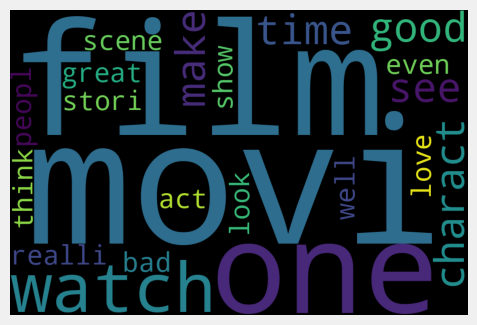

In [53]:
# topic 0
draw_word_cloud(0)

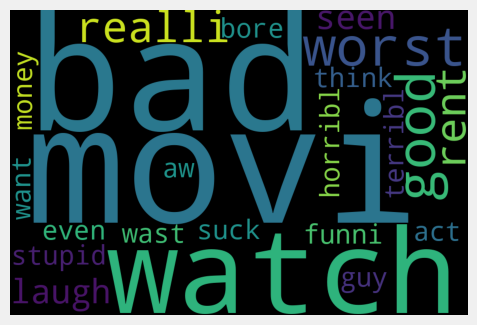

In [54]:
draw_word_cloud(1)